In [1]:
import mlrun
from dotenv import load_dotenv

### Load project

In [2]:
SOURCE = "https://github.com/mlrun/test-notebooks#main"
SECRETS_FILE = "mock_secrets.env"
DEFAULT_IMAGE = "mlrun/mlrun:1.5.1"

PARAMTERS = {
    "source" : SOURCE,
    "secrets_file" : SECRETS_FILE,
    "default_image" : DEFAULT_IMAGE
}

In [3]:
project = mlrun.get_or_create_project(name="test-project-setup", parameters=PARAMTERS)

> 2023-11-09 00:22:09,911 [info] Created and saved project: {'name': 'test-project-setup', 'from_template': None, 'overwrite': False, 'context': './', 'save': True}
Project Source: https://github.com/mlrun/test-notebooks#main
> 2023-11-09 00:22:09,922 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': './', 'error': '/User/test_project_setup'}
> 2023-11-09 00:22:10,014 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': 'src', 'error': '/User/test_project_setup/src'}
> 2023-11-09 00:22:10,034 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': 'src', 'error': '/User/test_project_setup/src'}
> 2023-11-09 00:22:10,350 [info] Project created successfully: {'project_name': 'test-project-setup', 'stored_in_db': True}


### Check source

In [4]:
assert project.source == SOURCE

In [5]:
assert project.spec.load_source_on_run == True

### Check functions

In [6]:
assert len(project.spec.functions) == 2

In [7]:
functions = ["get-data", "train"]
functions_check = []

In [8]:
for f in project.spec.functions:
    functions_check.append(f["name"])

In [9]:
assert functions == functions_check

### Check workflows

In [10]:
assert len(project.spec.workflows) == 1

In [11]:
workflows = ["main"]
workflows_check = []

In [12]:
for w in project.spec.workflows:
    workflows_check.append(w["name"])

In [13]:
assert workflows == workflows_check

### Check params

In [14]:
assert project.spec.params == PARAMTERS

### Check project image

In [15]:
assert project.default_image == DEFAULT_IMAGE

### Check project secrets

In [16]:
# Get dict with secret file contents for comparison
secret_dict = dict(mlrun.set_env_from_file(SECRETS_FILE, return_dict=True))

In [17]:
# Cannot check secret contents but can check keys
db = mlrun.get_run_db()
secret_keys = db.list_project_secret_keys(project=project.metadata.name)

In [18]:
assert set(secret_keys.secret_keys) == set(secret_dict.keys())

### Run workflow

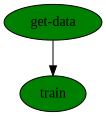

uid,start,state,name,parameters,results
...50b5bafd,Nov 09 00:22:42,completed,train,label_column=labelmodel_name=modeltest_size=0.2random_state=42,accuracy=0.986f1_score=0.9860834990059643precision_score=0.9959839357429718recall_score=0.9763779527559056
...49ec7d94,Nov 09 00:22:18,completed,get-data,label_column=label,num_rows=2500


In [19]:
run_uid = project.run(
    name="main",
    arguments={
        "dataset" : "https://s3.wasabisys.com/iguazio/data/batch-predict/training_set.parquet",
        "label_column" : "label",
        "model_name" : "model",
        "test_size" : 0.2,
        "random_state" : 42
    },
    watch=True,
    dirty=True
)

### Check run outputs

In [20]:
workflow_runs = project.list_runs(labels=f"workflow={run_uid}").to_objects()

In [21]:
assert len(workflow_runs) == 2

In [22]:
DATA_OUTPUTS = ['num_rows', 'cleaned_data']
TRAIN_OUTPUTS = [
    'accuracy',
    'f1_score',
    'precision_score',
    'recall_score',
    'feature-importance',
    'test_set',
    'confusion-matrix',
    'roc-curves',
    'calibration-curve',
    'model'
]

In [23]:
for run in workflow_runs:
    assert run.metadata.name in ["get-data", "train"]
    if run.metadata.name == "get-data":
        assert list(run.outputs.keys()) == DATA_OUTPUTS
    elif run.metadata.name == "train":
        assert list(run.outputs.keys()) == TRAIN_OUTPUTS

### Clean up

In [24]:
db.delete_project(name=project.metadata.name, deletion_strategy="cascade")

> 2023-11-09 00:23:01,764 [info] Project is being deleted: {'project_name': 'test-project-setup'}
> 2023-11-09 00:23:04,822 [info] Project deleted: {'project_name': 'test-project-setup'}
